In [1]:
%reload_ext autoreload
%autoreload 0
from pathlib import Path
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
#from fastai import *
#from fastai.text.all import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, recall_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader, SequentialSampler


In [2]:
model_dir = "/home/sm1073/.cache/huggingface/hub/models--zhihan1996--DNABERT-2-117M/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)

In [3]:
model = AutoModelForSequenceClassification.from_pretrained(model_dir, trust_remote_code=True)

/home/sm1073/.cache/huggingface/modules/transformers_modules/DNABERT-2-117M/bert_layers.py:127: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/sm1073/.cache/huggingface/hub/models--zhihan1996--DNABERT-2-117M/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
path = Path('/home/sm1073/Documents/independent_project/')

In [5]:
df = pd.read_csv(path/'x_inactivation_genes.csv')

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
class DNADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Sequence
        self.labels = dataframe.Label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        dna_sequence = str(self.text.iloc[index])
        inputs = self.tokenizer(dna_sequence, return_tensors='pt', max_length=self.max_len, padding='max_length', truncation=True)
        labels = self.labels.iloc[index]
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

In [8]:
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Accessing train loss
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])

        # Accessing eval loss
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])
#The checks prevent the callback from attempting ot access ekys that do not exist in the log history, producing key errors.
loss_logger = LossLoggingCallback()

In [9]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=20
)

In [10]:
train_dataset = DNADataset(train_df, tokenizer, max_len=512)
val_dataset = DNADataset(val_df, tokenizer, max_len=512)

In [11]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[loss_logger]
)

In [12]:
trainer.train()
results = trainer.evaluate()
print(results)

Step,Training Loss,Validation Loss
20,0.699600,0.698812
40,0.694800,0.699601
60,0.681000,0.699045
80,0.673200,0.700040
100,0.640900,0.695000
120,0.656500,0.678248
140,0.579300,0.635691


{'eval_loss': 0.6356908679008484, 'eval_runtime': 54.6502, 'eval_samples_per_second': 0.732, 'eval_steps_per_second': 0.091, 'epoch': 7.0}


In [37]:
print(len(loss_logger.train_losses))
print(len(loss_logger.eval_losses))
print(training_args.num_train_epochs)

24
6
3


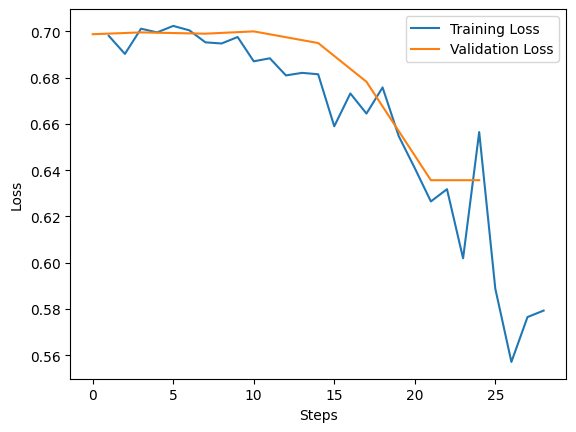

In [13]:
# Number of epochs
epochs = range(1, training_args.num_train_epochs + 1)

# Training and validation losses
train_losses = loss_logger.train_losses
eval_losses = loss_logger.eval_losses

# Adjust the epoch range for plotting
eval_epoch_indices = [i * len(train_losses) // len(eval_losses) for i in range(len(eval_losses))]

# Plotting
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(eval_epoch_indices, eval_losses, label='Validation Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
class DNADatasetForPrediction(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Sequence
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        dna_sequence = str(self.text.iloc[index])
        inputs = self.tokenizer(dna_sequence, return_tensors='pt', max_length=self.max_len, padding='max_length', truncation=True)
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten()
        }


In [15]:
#dataset
predict_dataset = DNADatasetForPrediction(df, tokenizer, max_len=512)
#dataloader
predict_dataloader = DataLoader(predict_dataset, sampler=SequentialSampler(predict_dataset), batch_size=8)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_f

In [16]:
predictions = []
with torch.no_grad():
    for batch in predict_dataloader:
        inputs = {
            'input_ids': batch['input_ids'],
            'attention_mask': batch['attention_mask']
        }
        outputs = model(**inputs)
        logits = outputs.logits
        predictions.extend(torch.softmax(logits, dim=1).cpu().numpy())

predictions = np.array(predictions)
pred_labels = np.argmax(predictions, axis=1)

In [17]:
true_labels = df['Label'].values

In [18]:
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
#extract probabilities for escape
escape_prob = predictions[:,1]
roc_auc = roc_auc_score(true_labels, escape_prob)

In [19]:
# Print the classification report
print(classification_report(true_labels, pred_labels))

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC score:{roc_auc}')

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       101
           1       0.82      0.87      0.84        99

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200

Accuracy: 0.84
Precision: 0.8413233082706768
Recall: 0.84
F1 Score: 0.8399039615846339
ROC AUC score:0.9066906690669067


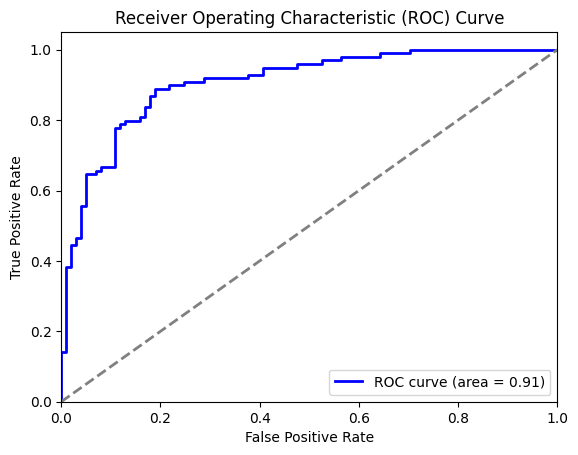

In [20]:
#Calculate the false positive, true positive and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, escape_prob)
#plot the curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()